<a href="https://colab.research.google.com/github/eugeneteoh/COMP6248-Deep-Learning/blob/master/lab_6/exercise/lab6ex_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

try:
    import pytorch_lightning as pl
except:
    !pip install pytorch-lightning
    import pytorch_lightning as pl

pl.seed_everything(0)

Global seed set to 0


0

## Dataset

In [2]:
from os.path import exists
if not exists('data'):
    !wget -O boat-data.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/eAhIkhhdxgmhRHj/download
    !unzip boat-data.zip

In [3]:
!ls data
!ls data/test

mf.jpg	README.md  test  train	valid
Alilaguna  Lanciafino10m	    Mototopo	     Sandoloaremi
Ambulanza  Motobarca		    Patanella	     Topa
Barchino   Motopontonerettangolare  Polizia	     VaporettoACTV
Gondola    MotoscafoACTV	    Raccoltarifiuti  Water


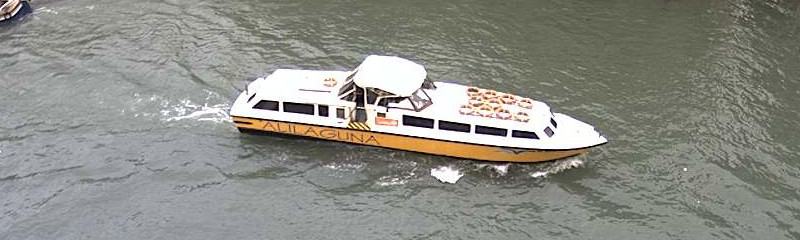

In [4]:
from IPython.display import Image
Image("data/test/Alilaguna/20130412_064059_20202.jpg")

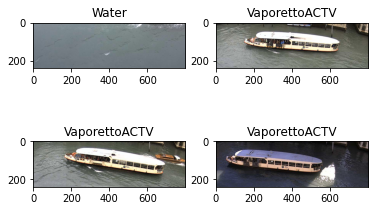

In [5]:
%matplotlib inline

# Plot ad hoc data instances
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms 
import matplotlib
import matplotlib.pyplot as plt
import numpy

transform = transforms.Compose([
    transforms.Resize((240, 800)),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# generate the first batch
(batch_images, batch_labels) = train_loader.__iter__().__next__()

# plot 4 images
plt.subplot(221).set_title(train_dataset.classes[batch_labels[0]])
plt.imshow(batch_images[0].permute(1, 2, 0), aspect='equal')
plt.subplot(222).set_title(train_dataset.classes[batch_labels[1]])
plt.imshow(batch_images[1].permute(1, 2, 0), aspect='equal')
plt.subplot(223).set_title(train_dataset.classes[batch_labels[2]])
plt.imshow(batch_images[2].permute(1, 2, 0), aspect='equal')
plt.subplot(224).set_title(train_dataset.classes[batch_labels[3]])
plt.imshow(batch_images[3].permute(1, 2, 0), aspect='equal')

# show the plot
plt.show()

In [6]:
# the number of images that will be processed in a single step
batch_size=128
# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(30, 100)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder("data/valid", transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder("data/test", transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Task 1

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

try:
    import wandb
except:
    !pip install wandb
    import wandb

from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.loggers import WandbLogger


In [25]:
class TransferLearning1(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        
        backbone = models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        self.feature_extractor.eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
        return loss

    # logic for a single validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    # logic for a single testing step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {
       'optimizer': optimizer,
       'lr_scheduler': scheduler,
       'monitor': 'train_loss'
        }


In [26]:
from pytorch_lightning.callbacks import LearningRateMonitor

In [28]:
# Init our model
model = TransferLearning1(len(train_dataset.classes))

# Initialize wandb logger
wandb_logger = WandbLogger(name='model1', project='lab6', reinit=True)

# lr monitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50,
                     gpus=1, 
                     logger=wandb_logger,
                     deterministic=True,
                     callbacks=[lr_monitor]
                     )

# Train the model ⚡🚅⚡
trainer.fit(model, train_loader, val_loader)

# Evaluate the model on the held out test set ⚡⚡
trainer.test(model, test_loader)

# Close wandb run
# wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 23.5 M
1 | classifier        | Linear     | 32.8 K
-------------------------------------------------
32.8 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.163    Total estimated model params size (MB)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7862537503242493, 'test_loss': 0.8108122944831848}
--------------------------------------------------------------------------------


[{'test_acc': 0.7862537503242493, 'test_loss': 0.8108122944831848}]

In [44]:
iter_loader = iter(test_loader)

In [47]:
next(iter_loader)[0].shape

torch.Size([128, 3, 30, 100])

In [66]:
predictions = []
for batch in test_loader:
    x, y = batch
    x = x.to('cuda')
    y = y.to('cuda')
    logits = model(x)
    predictions.append(logits)

In [72]:
predictions = torch.cat(predictions, 0)

In [84]:
predicted_classes = predictions.argmax(1).cpu()
true_classes = list(x for (_,x) in test_dataset.samples)

from sklearn import metrics
import pandas as pd
df_metrics = metrics.classification_report(true_classes, predicted_classes, output_dict=True)
df_metrics = pd.DataFrame(df_metrics).T
df_metrics = df_metrics.round(3)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
print(df_metrics.to_latex(caption='Model 1 classification report.', label='tab:model1-class-report'))

\begin{table}
\centering
\caption{Model 1 classification report.}
\label{tab:model1-class-report}
\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &   support \\
\midrule
0            &      0.412 &   0.368 &     0.389 &    19.000 \\
1            &      0.556 &   0.455 &     0.500 &    22.000 \\
2            &      0.636 &   0.137 &     0.226 &    51.000 \\
3            &      0.000 &   0.000 &     0.000 &     3.000 \\
4            &      0.000 &   0.000 &     0.000 &     7.000 \\
5            &      0.179 &   0.085 &     0.115 &    59.000 \\
6            &      0.667 &   0.667 &     0.667 &     3.000 \\
7            &      0.000 &   0.000 &     0.000 &     1.000 \\
8            &      0.672 &   0.861 &     0.755 &   274.000 \\
9            &      0.367 &   0.541 &     0.437 &    74.000 \\
10           &      1.000 &   0.067 &     0.125 &    15.000 \\
11           &      0.647 &   0.579 &     0.611 &    19.000 \\
12           &      0.000 &   0.000 &     0.000 &   